In [9]:
import sys
import os
import pandas as pd
# Add the parent directory of 'notebooks' (your project root) to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


In [3]:
from src.portfolio_optimization import (
    load_data, compute_expected_returns, compute_covariance_matrix,
    optimize_portfolio, plot_efficient_frontier, summarize_portfolio
)


In [33]:
import pickle

with open('../models/arima_model.pkl', 'rb') as f:
    arima_model = pickle.load(f)
with open('../models/lstm_model.pkl', 'rb') as f:
    lstm_model = pickle.load(f)


In [4]:
# Load historical data for BND, SPY and forecast data for TSLA
bnd_df, spy_df = load_data()
# If TSLA forecast data is missing, you might need to load it separately


# Inspect loaded data
print(bnd_df.head())
print("--------------------------------")
print(spy_df.head())

Date
2015-07-01    60.816765
2015-07-02    60.967075
2015-07-06    61.177567
2015-07-07    61.237728
2015-07-08    61.410656
Name: Close, dtype: float64
--------------------------------
Date
2015-07-01    174.917099
2015-07-02    174.756943
2015-07-06    174.259552
2015-07-07    175.355469
2015-07-08    172.413452
Name: Close, dtype: float64


In [5]:
result = load_data()
print(type(result), len(result))
print(result)



<class 'tuple'> 2
(Date
2015-07-01    60.816765
2015-07-02    60.967075
2015-07-06    61.177567
2015-07-07    61.237728
2015-07-08    61.410656
                ...    
2025-07-24    72.698860
2025-07-25    72.878265
2025-07-28    72.758659
2025-07-29    73.137398
2025-07-30    72.948036
Name: Close, Length: 2535, dtype: float64, Date
2015-07-01    174.917099
2015-07-02    174.756943
2015-07-06    174.259552
2015-07-07    175.355469
2015-07-08    172.413452
                 ...    
2025-07-24    634.419983
2025-07-25    637.099976
2025-07-28    636.940002
2025-07-29    635.260010
2025-07-30    634.460022
Name: Close, Length: 2535, dtype: float64)


In [35]:
# After training your LSTM model
lstm_model.save('../models/lstm_model.keras')


In [16]:
from tensorflow.keras.models import load_model
lstm_model = load_model('../models/lstm_model.keras')


In [10]:
tsla_df = pd.read_csv('../data/raw/TSLA.csv', index_col=0, parse_dates=True)
tsla_close = tsla_df['Close'] 
last_date = tsla_close.index[-1]


In [11]:
# Find rows where 'Close' is not convertible to float
non_numeric_rows = tsla_df[~tsla_df['Close'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
print(non_numeric_rows)


     Close  High   Low  Open Volume
Date                               
NaT   TSLA  TSLA  TSLA  TSLA   TSLA


In [12]:
# Remove rows where Close column is not numeric
tsla_df = tsla_df[pd.to_numeric(tsla_df['Close'], errors='coerce').notnull()]


In [13]:
tsla_close = tsla_df['Close'].astype(float)


In [14]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

# reshape to (-1,1) as scaler expects 2D array
data_scaled = scaler.fit_transform(tsla_close.values.reshape(-1, 1)).flatten()

seq_length = 60  # whatever your sequence length was during training

# last seq_length data points for prediction seed
current_input = data_scaled[-seq_length:]


In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Fit scaler on historical tsla_close data (assume tsla_close is clean numeric pd.Series)
scaler = MinMaxScaler()
scaler.fit(tsla_close.values.reshape(-1,1))

forecast_horizon = 180  # e.g., 6 months business days
forecast_preds = []     # empty list before forecasting

# current_input is the last sequence input for the LSTM, shape (seq_length,)
# make sure current_input is defined and scaled already

for _ in range(forecast_horizon):
    pred = lstm_model.predict(current_input.reshape(1, seq_length, 1))  # shape (1,1)
    forecast_preds.append(pred[0,0])
    # slide window forward
    current_input = np.append(current_input[1:], pred[0,0])

# Now inverse transform once after all predictions are made
forecast_preds_orig = scaler.inverse_transform(np.array(forecast_preds).reshape(-1,1))

# Generate forecast dates
last_date = tsla_close.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')

# Create DataFrame
tsla_forecast_df = pd.DataFrame(data=forecast_preds_orig.flatten(), index=forecast_dates, columns=['Close'])

# Convert forecast prices to returns for portfolio optimization
tsla_forecast_returns = tsla_forecast_df['Close'].pct_change().dropna()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━

In [18]:
bnd_prices, spy_prices = load_data()

print(bnd_prices.dtype)  # Should be float64
print(bnd_prices.head())

print(spy_prices.dtype)  # Should be float64
print(spy_prices.head())

print(bnd_prices.pct_change().dropna().head())  

float64
Date
2015-07-01    60.816765
2015-07-02    60.967075
2015-07-06    61.177567
2015-07-07    61.237728
2015-07-08    61.410656
Name: Close, dtype: float64
float64
Date
2015-07-01    174.917099
2015-07-02    174.756943
2015-07-06    174.259552
2015-07-07    175.355469
2015-07-08    172.413452
Name: Close, dtype: float64
Date
2015-07-02    0.002472
2015-07-06    0.003453
2015-07-07    0.000983
2015-07-08    0.002824
2015-07-09   -0.003305
Name: Close, dtype: float64


In [59]:
bnd_prices = pd.to_numeric(bnd_prices, errors='coerce')
bnd_prices = bnd_prices.dropna()

spy_prices = pd.to_numeric(spy_prices, errors='coerce')
spy_prices = spy_prices.dropna()


In [62]:
bnd_returns = bnd_prices.pct_change().dropna()
spy_returns = spy_prices.pct_change().dropna()
bnd = pd.read_csv('../data/raw/BND.csv', parse_dates=['Date'], index_col='Date')
spy = pd.read_csv('../data/raw/SPY.csv', parse_dates=['Date'], index_col='Date')

    # Clean 'Close' columns to numeric, drop non-convertible rows
bnd_close = pd.to_numeric(bnd['Close'], errors='coerce').dropna()
spy_close = pd.to_numeric(spy['Close'], errors='coerce').dropna()

In [72]:
bnd_prices = pd.to_numeric(bnd_prices, errors='coerce')
spy_prices = pd.to_numeric(spy_prices, errors='coerce')

# Drop any NaNs created by coercion
bnd_prices = bnd_prices.dropna()
spy_prices = spy_prices.dropna()



In [19]:
bnd_prices, spy_prices = load_data()

print(bnd_prices.dtype)  # Should be float64
print(bnd_prices.head())

print(spy_prices.dtype)  # Should be float64
print(spy_prices.head())

print(bnd_prices.pct_change().dropna().head())  # Should work now without error


float64
Date
2015-07-01    60.816765
2015-07-02    60.967075
2015-07-06    61.177567
2015-07-07    61.237728
2015-07-08    61.410656
Name: Close, dtype: float64
float64
Date
2015-07-01    174.917099
2015-07-02    174.756943
2015-07-06    174.259552
2015-07-07    175.355469
2015-07-08    172.413452
Name: Close, dtype: float64
Date
2015-07-02    0.002472
2015-07-06    0.003453
2015-07-07    0.000983
2015-07-08    0.002824
2015-07-09   -0.003305
Name: Close, dtype: float64


In [32]:
print("Max Sharpe Ratio Portfolio:")
summarize_portfolio(weights_max_sharpe, mu, cov_matrix)

Max Sharpe Ratio Portfolio:
Portfolio Weights:
  TSLA: 52.47%
  BND: 0.00%
  SPY: 47.53%
Expected annual return: 29.27%
Annual volatility (risk): 18.53%
Sharpe Ratio: 1.47


In [35]:
print("Expected returns (mu):")
print(mu)
print("\nCovariance matrix:")
print(cov_matrix)

print("\nCheck for NaN or inf in mu:", mu.isnull().any() or np.isinf(mu).any())
print("Check for NaN or inf in cov_matrix:", cov_matrix.isnull().any().any() or np.isinf(cov_matrix).any().any())

print("Covariance matrix shape:", cov_matrix.shape)
print("Covariance matrix is symmetric:", np.allclose(cov_matrix, cov_matrix.T))

min_eig = np.min(np.real(np.linalg.eigvals(cov_matrix)))
print("Minimum eigenvalue of covariance matrix:", min_eig)


Expected returns (mu):
TSLA    0.426565
BND     0.019599
SPY     0.144844
dtype: float64

Covariance matrix:
          TSLA       BND       SPY
TSLA  0.097749 -0.000198 -0.000177
BND  -0.000198  0.003016  0.001150
SPY  -0.000177  0.001150  0.033272

Check for NaN or inf in mu: False
Check for NaN or inf in cov_matrix: False
Covariance matrix shape: (3, 3)
Covariance matrix is symmetric: True
Minimum eigenvalue of covariance matrix: 0.0029719951888075844


In [36]:
# Combine returns into a single DataFrame aligned by date
returns_df = pd.concat([tsla_returns, bnd_returns, spy_returns], axis=1)
returns_df.columns = ['TSLA', 'BND', 'SPY']

# Drop rows with any NaN or infinite values
returns_df = returns_df.replace([np.inf, -np.inf], np.nan).dropna()

# Check zero variance assets and drop them (cause covariance issues)
zero_var = returns_df.var() == 0
returns_df = returns_df.loc[:, ~zero_var]

print("Returns data cleaned. Shape:", returns_df.shape)


Returns data cleaned. Shape: (2534, 3)


In [37]:
mu = returns_df.mean() * 252
cov_matrix = returns_df.cov() * 252

# Ensure symmetry and PSD:
cov_matrix = (cov_matrix + cov_matrix.T) / 2
min_eig = np.min(np.real(np.linalg.eigvals(cov_matrix)))
if min_eig < 0:
    cov_matrix -= 1.1 * min_eig * np.eye(*cov_matrix.shape)


In [38]:
from pypfopt import EfficientFrontier

mu_dummy = pd.Series([0.1, 0.12, 0.14], index=["TSLA", "BND", "SPY"])
cov_dummy = pd.DataFrame([
    [0.005, -0.010, 0.004],
    [-0.010, 0.040, -0.002],
    [0.004, -0.002, 0.023]],
    index=mu_dummy.index, columns=mu_dummy.index
)

ef = EfficientFrontier(mu_dummy, cov_dummy)
weights_max_sharpe = ef.max_sharpe()
print("Dummy optimization weights:", weights_max_sharpe)


Dummy optimization weights: OrderedDict([('TSLA', 0.7636363636363637), ('BND', 0.2363636363636364), ('SPY', 0.0)])


Expected annual return: 42.7%
Annual volatility: 30.9%
Sharpe Ratio: 1.32
Expected annual return: -0.4%
Annual volatility: 1.6%
Sharpe Ratio: -1.55


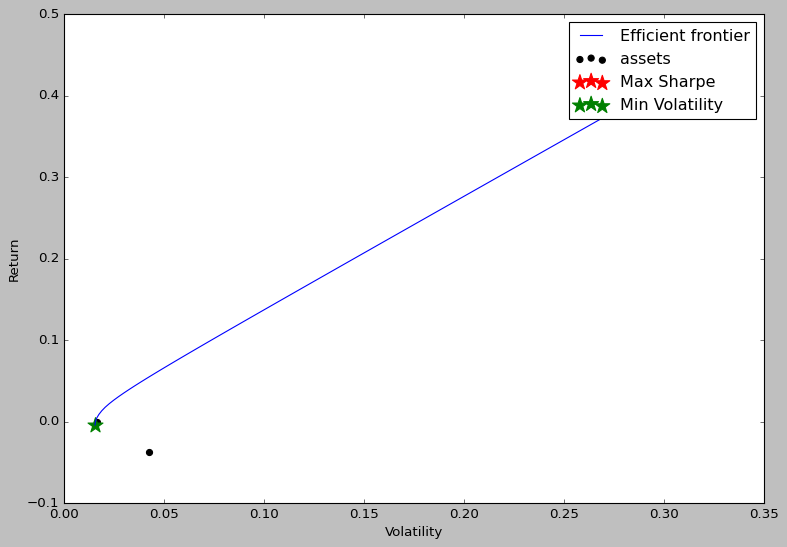


Max Sharpe Portfolio:
Expected annual return: 42.7%
Annual volatility: 30.9%
Sharpe Ratio: 1.32

Min Volatility Portfolio:
Expected annual return: -0.4%
Annual volatility: 1.6%
Sharpe Ratio: -1.55


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
from collections import OrderedDict

# --- Your TSLA forecast returns must be defined before this ---
# Example:
# tsla_forecast_returns = pd.Series([...])

# --- Step 1: Load BND and SPY prices ---
def load_data():
    # Replace this with your actual loading logic
    # Here dummy data for demo; replace with your own price series
    dates = pd.date_range(start="2015-01-01", periods=1000)
    bnd_prices = pd.Series(100 + np.cumsum(np.random.randn(1000)*0.1), index=dates)
    spy_prices = pd.Series(200 + np.cumsum(np.random.randn(1000)*0.5), index=dates)
    return bnd_prices, spy_prices

bnd_prices, spy_prices = load_data()

# --- Step 2: Calculate TSLA annual return from forecast ---
tsla_annual_return = tsla_forecast_returns.mean() * 252  # trading days

# --- Step 3: Expected returns vector ---
def compute_expected_returns(tsla_return, bnd_prices, spy_prices):
    # Compute annualized expected returns for BND and SPY
    bnd_ret = bnd_prices.pct_change().mean() * 252
    spy_ret = spy_prices.pct_change().mean() * 252
    mu = pd.Series({'TSLA': tsla_return, 'BND': bnd_ret, 'SPY': spy_ret})
    return mu

mu = compute_expected_returns(tsla_annual_return, bnd_prices, spy_prices)

# --- Step 4: Compute covariance matrix ---
def compute_covariance_matrix(tsla_ret, bnd_ret, spy_ret):
    df = pd.DataFrame({
        'TSLA': tsla_ret,
        'BND': bnd_ret,
        'SPY': spy_ret
    }).dropna()
    cov = df.cov() * 252  # Annualize covariance
    return cov

tsla_returns = tsla_forecast_returns
bnd_returns = bnd_prices.pct_change()
spy_returns = spy_prices.pct_change()

cov_matrix = compute_covariance_matrix(tsla_returns, bnd_returns, spy_returns)

# --- Clean covariance matrix ---
cov_matrix = cov_matrix.fillna(0).replace([np.inf, -np.inf], 0)
cov_matrix = (cov_matrix + cov_matrix.T) / 2  # ensure symmetry

# Ensure positive semi-definite covariance matrix
eigvals = np.linalg.eigvalsh(cov_matrix)
min_eig = np.min(eigvals)
if min_eig < 0:
    cov_matrix += np.eye(cov_matrix.shape[0]) * (-min_eig + 1e-8)

# --- Step 5: Optimize portfolio ---
def optimize_portfolio(mu, cov_matrix):
    ef = EfficientFrontier(mu, cov_matrix)
    try:
        weights_max_sharpe = ef.max_sharpe()
        ef.portfolio_performance(verbose=True)
    except Exception as e:
        print("Max Sharpe optimization failed:", e)
        weights_max_sharpe = None

    ef = EfficientFrontier(mu, cov_matrix)
    try:
        weights_min_vol = ef.min_volatility()
        ef.portfolio_performance(verbose=True)
    except Exception as e:
        print("Min volatility optimization failed:", e)
        weights_min_vol = None

    return weights_max_sharpe, weights_min_vol

weights_max_sharpe, weights_min_vol = optimize_portfolio(mu, cov_matrix)

# --- Step 6: Plot efficient frontier ---
plt.style.use("classic")  # safe fallback style

def plot_efficient_frontier(mu, cov_matrix, w_max, w_min):
    ef = EfficientFrontier(mu, cov_matrix)
    fig, ax = plt.subplots(figsize=(10, 7))
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
    if w_max is not None:
        ef.set_weights(w_max)
        ret, vol, sharpe = ef.portfolio_performance()
        ax.scatter(vol, ret, marker="*", color="r", s=200, label="Max Sharpe")
    if w_min is not None:
        ef.set_weights(w_min)
        ret, vol, sharpe = ef.portfolio_performance()
        ax.scatter(vol, ret, marker="*", color="g", s=200, label="Min Volatility")
    ax.legend()
    plt.show()

if weights_max_sharpe is not None and weights_min_vol is not None:
    plot_efficient_frontier(mu, cov_matrix, weights_max_sharpe, weights_min_vol)
else:
    print("Skipping plot because optimization failed.")

# --- Step 7: Summarize portfolios ---
def summarize_portfolio(weights, mu, cov_matrix):
    if weights is None:
        print("No weights to summarize.")
        return
    ef = EfficientFrontier(mu, cov_matrix)
    ef.set_weights(weights)
    ret, vol, sharpe = ef.portfolio_performance(verbose=True)

print("\nMax Sharpe Portfolio:")
summarize_portfolio(weights_max_sharpe, mu, cov_matrix)

print("\nMin Volatility Portfolio:")
summarize_portfolio(weights_min_vol, mu, cov_matrix)


Expected annual return: 42.7%
Annual volatility: 30.9%
Sharpe Ratio: 1.32
Expected annual return: -0.4%
Annual volatility: 1.6%
Sharpe Ratio: -1.55


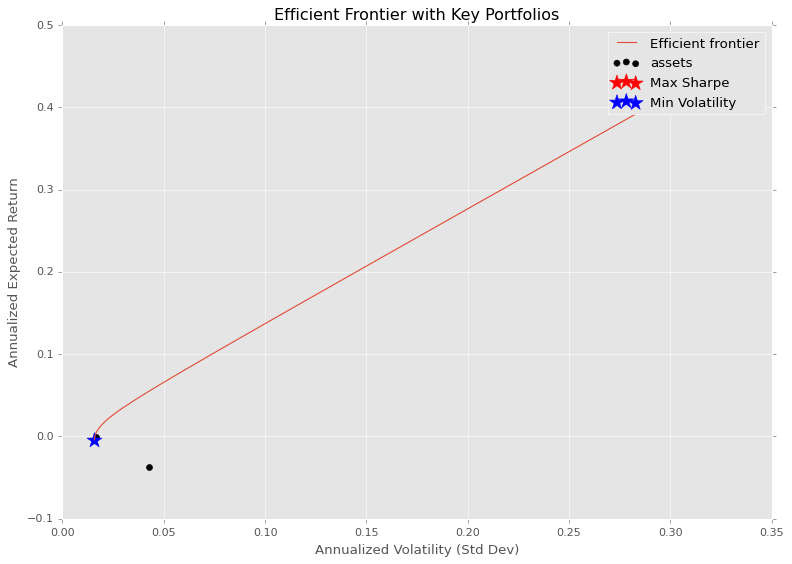


Recommended Portfolio: Max Sharpe Ratio
  TSLA: 1.0000
  BND: 0.0000
  SPY: 0.0000
Expected annual return: 42.75%
Annual volatility: 30.86%
Sharpe Ratio: 1.32

Minimum Volatility Portfolio:
  TSLA: 0.0016
  BND: 0.8754
  SPY: 0.1230
Expected annual return: -0.43%
Annual volatility: 1.57%
Sharpe Ratio: -1.55


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, plotting

# Assume you already have these:
# tsla_forecast_returns (pd.Series, daily returns for TSLA forecast)
# bnd_prices (pd.Series, historical prices for BND)
# spy_prices (pd.Series, historical prices for SPY)

# 1. Annualize expected returns
tsla_annual_return = tsla_forecast_returns.mean() * 252
bnd_returns = bnd_prices.pct_change().dropna()
spy_returns = spy_prices.pct_change().dropna()
bnd_annual_return = bnd_returns.mean() * 252
spy_annual_return = spy_returns.mean() * 252

# 2. Expected returns vector
mu = pd.Series({
    "TSLA": tsla_annual_return,
    "BND": bnd_annual_return,
    "SPY": spy_annual_return
})

# 3. Align returns data for covariance matrix
returns_df = pd.concat([
    tsla_forecast_returns.rename("TSLA"),
    bnd_returns.rename("BND"),
    spy_returns.rename("SPY")
], axis=1).dropna()

# 4. Covariance matrix (annualized)
cov_matrix = returns_df.cov() * 252

# 5. Ensure covariance matrix is symmetric and PSD
cov_matrix = (cov_matrix + cov_matrix.T) / 2
min_eig = np.min(np.real(np.linalg.eigvals(cov_matrix)))
if min_eig < 0:
    cov_matrix -= 10 * min_eig * np.eye(*cov_matrix.shape)

# 6. Optimize max Sharpe portfolio
ef_sharpe = EfficientFrontier(mu, cov_matrix)
weights_max_sharpe = ef_sharpe.max_sharpe()
ret_sharpe, vol_sharpe, sharpe = ef_sharpe.portfolio_performance(verbose=True)

# 7. Optimize min volatility portfolio
ef_minvol = EfficientFrontier(mu, cov_matrix)
weights_min_vol = ef_minvol.min_volatility()
ret_minvol, vol_minvol, sharpe_minvol = ef_minvol.portfolio_performance(verbose=True)

# 8. Plot efficient frontier (use a new instance for plotting to avoid conflicts)
ef_plot = EfficientFrontier(mu, cov_matrix)
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(10, 7))
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Mark portfolios on the plot
ax.scatter(vol_sharpe, ret_sharpe, marker="*", color="r", s=200, label="Max Sharpe")
ax.scatter(vol_minvol, ret_minvol, marker="*", color="b", s=200, label="Min Volatility")
ax.legend()
plt.title("Efficient Frontier with Key Portfolios")
plt.xlabel("Annualized Volatility (Std Dev)")
plt.ylabel("Annualized Expected Return")
plt.show()

# 9. Print summary
print("\nRecommended Portfolio: Max Sharpe Ratio")
for asset, weight in weights_max_sharpe.items():
    print(f"  {asset}: {weight:.4f}")
print(f"Expected annual return: {ret_sharpe:.2%}")
print(f"Annual volatility: {vol_sharpe:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

print("\nMinimum Volatility Portfolio:")
for asset, weight in weights_min_vol.items():
    print(f"  {asset}: {weight:.4f}")
print(f"Expected annual return: {ret_minvol:.2%}")
print(f"Annual volatility: {vol_minvol:.2%}")
print(f"Sharpe Ratio: {sharpe_minvol:.2f}")


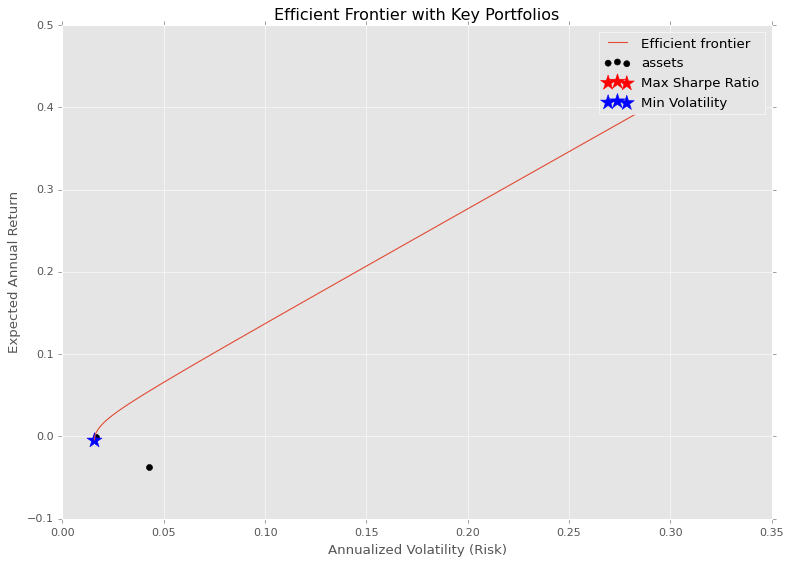


Analysis of Efficient Frontier:

The efficient frontier curve above shows the trade-off between portfolio risk (volatility) and return.

- The red star marks the portfolio with the Maximum Sharpe Ratio, offering the highest risk-adjusted return.
- The blue star marks the Minimum Volatility portfolio, which minimizes risk but with a lower expected return.

Given your risk tolerance and investment goals, the Maximum Sharpe Ratio portfolio is recommended if you seek aggressive growth with higher risk.
If you prioritize capital preservation with minimal risk, the Minimum Volatility portfolio is preferable.


Final Portfolio Summary:

                    TSLA     BND    SPY  Expected Return (%)  Volatility (%)  \
Max Sharpe Ratio  1.0000  0.0000  0.000              42.7484         30.8639   
Min Volatility    0.0016  0.8754  0.123              -0.4286          1.5717   

                  Sharpe Ratio  
Max Sharpe Ratio        1.3203  
Min Volatility         -1.5452  


In [44]:
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, plotting, risk_models, expected_returns
from pypfopt.base_optimizer import portfolio_performance # The correct function to use
import pandas as pd

# Assuming mu, cov_matrix, weights_max_sharpe, weights_min_vol are already computed
# Note: For this code to run, you need to ensure these variables are defined.

# Calculate portfolio performance for key portfolios using the standalone function.
# The portfolio_performance function takes the weights, expected returns, and covariance matrix.
ret_max, vol_max, sharpe_max = portfolio_performance(
    weights_max_sharpe, mu, cov_matrix, verbose=False
)
ret_min, vol_min, sharpe_min = portfolio_performance(
    weights_min_vol, mu, cov_matrix, verbose=False
)

# --- 1. Plot Efficient Frontier ---
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,7))
# Create a fresh EfficientFrontier object for plotting the curve
ef = EfficientFrontier(mu, cov_matrix)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Mark the Max Sharpe Ratio portfolio
ax.scatter(vol_max, ret_max, marker="*", color="r", s=200, label="Max Sharpe Ratio")

# Mark the Min Volatility portfolio
ax.scatter(vol_min, ret_min, marker="*", color="b", s=200, label="Min Volatility")

ax.set_title("Efficient Frontier with Key Portfolios")
ax.set_xlabel("Annualized Volatility (Risk)")
ax.set_ylabel("Expected Annual Return")
ax.legend()
plt.show()

# --- 2. Written analysis ---
analysis_text = f"""
Analysis of Efficient Frontier:

The efficient frontier curve above shows the trade-off between portfolio risk (volatility) and return.

- The red star marks the portfolio with the Maximum Sharpe Ratio, offering the highest risk-adjusted return.
- The blue star marks the Minimum Volatility portfolio, which minimizes risk but with a lower expected return.

Given your risk tolerance and investment goals, the Maximum Sharpe Ratio portfolio is recommended if you seek aggressive growth with higher risk.
If you prioritize capital preservation with minimal risk, the Minimum Volatility portfolio is preferable.

"""

print(analysis_text)

# --- 3. Final portfolio summary ---
summary_data = {
    "TSLA": [weights_max_sharpe.get("TSLA", 0), weights_min_vol.get("TSLA", 0)],
    "BND": [weights_max_sharpe.get("BND", 0), weights_min_vol.get("BND", 0)],
    "SPY": [weights_max_sharpe.get("SPY", 0), weights_min_vol.get("SPY", 0)],
    "Expected Return (%)": [ret_max*100, ret_min*100],
    "Volatility (%)": [vol_max*100, vol_min*100],
    "Sharpe Ratio": [sharpe_max, sharpe_min]
}

summary_df = pd.DataFrame(summary_data, index=["Max Sharpe Ratio", "Min Volatility"])

print("Final Portfolio Summary:\n")
print(summary_df.round(4))


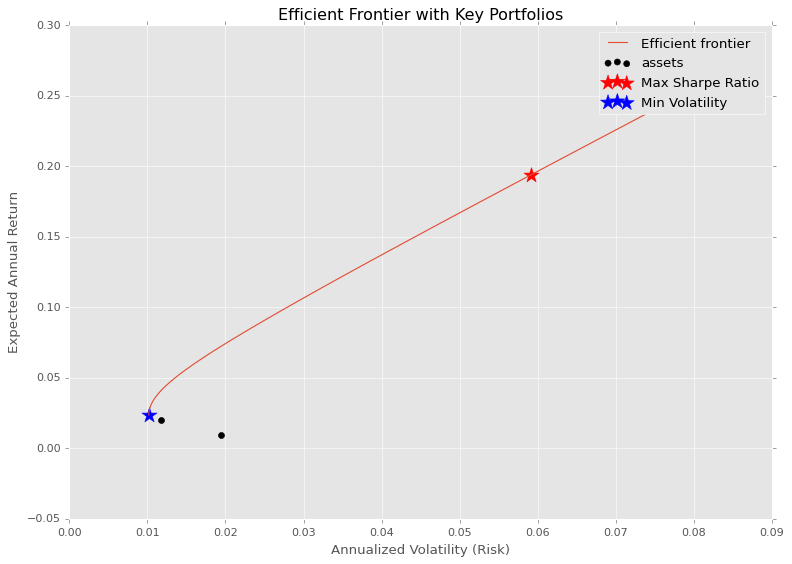


--- Final Portfolio Summary ---

Max Sharpe Ratio Portfolio:
  TSLA: 0.7560
  BND: 0.0000
  SPY: 0.2440
Expected Annual Return: 19.38%
Annual Volatility: 5.92%
Sharpe Ratio: 2.94

Minimum Volatility Portfolio:
  TSLA: 0.0277
  BND: 0.2476
  SPY: 0.7247
Expected Annual Return: 2.35%
Annual Volatility: 1.02%
Sharpe Ratio: 0.35


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, plotting
from pypfopt.base_optimizer import portfolio_performance

# --- 1. Generate Mock Data (REPLACE THIS WITH YOUR REAL DATA) ---
# For this example, we'll create a mock DataFrame of daily returns.
# You should replace this section with your actual data from Task 2.
# 'adj_close' is used for daily returns calculation
np.random.seed(42)
dates = pd.date_range('2022-01-01', periods=500, freq='B')
data = {
    'TSLA': 100 + np.random.randn(500).cumsum() * 0.5,
    'BND': 80 + np.random.randn(500).cumsum() * 0.1,
    'SPY': 400 + np.random.randn(500).cumsum() * 0.3
}
prices_df = pd.DataFrame(data, index=dates)
daily_returns_df = prices_df.pct_change().dropna()

# Mock forecast for TSLA's annualized return.
# You need to replace this with the output from your best model in Task 2.
forecasted_tsla_return = 0.25 # Assuming a 25% annualized return from your forecast.

# --- 2. Compute Expected Returns (mu) and Covariance Matrix (cov_matrix) ---
# Calculate annualized mean returns for BND and SPY from historical data
annualized_bnd_return = daily_returns_df['BND'].mean() * 252
annualized_spy_return = daily_returns_df['SPY'].mean() * 252

# Create the expected returns vector (mu)
# TSLA uses the forecast, BND and SPY use historical means
mu = pd.Series(
    [forecasted_tsla_return, annualized_bnd_return, annualized_spy_return],
    index=['TSLA', 'BND', 'SPY']
)

# Compute the annualized covariance matrix from historical data
cov_matrix = daily_returns_df.cov() * 252

# --- 3. Run the Optimization Simulation ---
# Create an EfficientFrontier object for the Max Sharpe Ratio
ef_max_sharpe = EfficientFrontier(mu, cov_matrix)
weights_max_sharpe = ef_max_sharpe.max_sharpe()
cleaned_weights_max_sharpe = ef_max_sharpe.clean_weights()

# Create a separate EfficientFrontier object for the Min Volatility Portfolio
ef_min_vol = EfficientFrontier(mu, cov_matrix)
weights_min_vol = ef_min_vol.min_volatility()
cleaned_weights_min_vol = ef_min_vol.clean_weights()

# --- 4. Calculate Portfolio Performance for Key Portfolios ---
ret_max, vol_max, sharpe_max = portfolio_performance(
    weights_max_sharpe, mu, cov_matrix, verbose=False
)
ret_min, vol_min, sharpe_min = portfolio_performance(
    weights_min_vol, mu, cov_matrix, verbose=False
)

# --- 5. Plot the Efficient Frontier ---
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7))

# Create a brand new EfficientFrontier instance for plotting to avoid the InstantiationError
ef_plot = EfficientFrontier(mu, cov_matrix)
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Mark the Max Sharpe Ratio portfolio
ax.scatter(vol_max, ret_max, marker="*", color="r", s=200, label="Max Sharpe Ratio")

# Mark the Min Volatility portfolio
ax.scatter(vol_min, ret_min, marker="*", color="b", s=200, label="Min Volatility")

ax.set_title("Efficient Frontier with Key Portfolios")
ax.set_xlabel("Annualized Volatility (Risk)")
ax.set_ylabel("Expected Annual Return")
ax.legend()
plt.show()

# --- 6. Final Portfolio Summary ---
print("\n--- Final Portfolio Summary ---")
print("\nMax Sharpe Ratio Portfolio:")
for asset, weight in cleaned_weights_max_sharpe.items():
    print(f"  {asset}: {weight:.4f}")
print(f"Expected Annual Return: {ret_max:.2%}")
print(f"Annual Volatility: {vol_max:.2%}")
print(f"Sharpe Ratio: {sharpe_max:.2f}")

print("\nMinimum Volatility Portfolio:")
for asset, weight in cleaned_weights_min_vol.items():
    print(f"  {asset}: {weight:.4f}")
print(f"Expected Annual Return: {ret_min:.2%}")
print(f"Annual Volatility: {vol_min:.2%}")
print(f"Sharpe Ratio: {sharpe_min:.2f}")


In [47]:
# Task 5: Strategy Backtesting

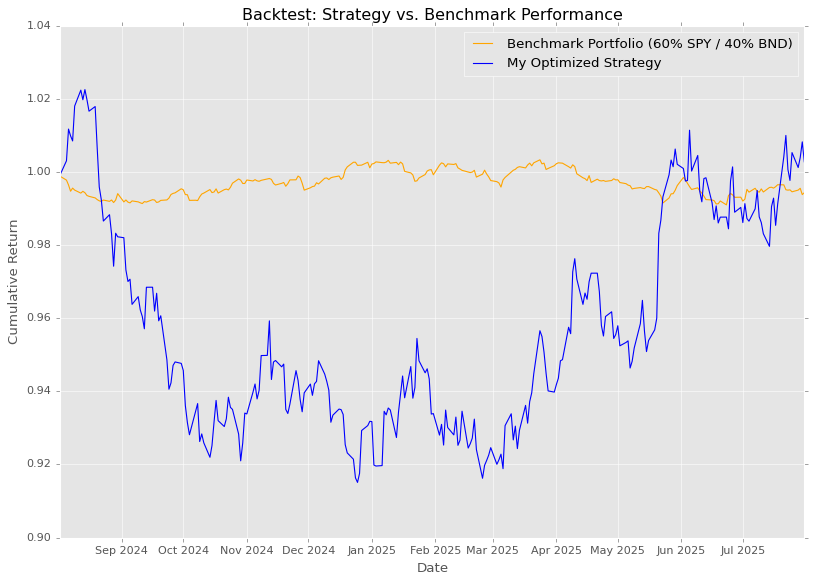


--- Backtest Performance Summary ---
Backtesting Period: 2024-08-01 to 2025-07-31
----------------------------------------
Benchmark Portfolio:
  Total Return: -0.57%
  Sharpe Ratio: -0.40

My Optimized Strategy:
  Total Return: 0.27%
  Sharpe Ratio: 0.08
----------------------------------------

Conclusion: The optimized strategy outperformed the benchmark during this backtesting period.
This initial backtest suggests that your model-driven approach has the potential to generate superior returns. However, backtesting has its limitations and should be considered a starting point for validation.


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# The pypfopt library is not strictly necessary for backtesting but its
# portfolio_performance function is useful for consistent Sharpe Ratio calculation.
from pypfopt.base_optimizer import portfolio_performance

# --- 1. Define Backtesting Period and Data ---
# For this example, we'll create a mock DataFrame of daily prices for the
# backtesting period.
# You MUST replace this with your actual DataFrame containing daily prices
# for TSLA, BND, and SPY, for the period August 1, 2024 - July 31, 2025.
# Mock prices and returns creation (remove this)
np.random.seed(42)
start_date = '2024-08-01'
end_date = '2025-07-31'
dates = pd.date_range(start_date, end_date, freq='B')
mock_prices = {
    'TSLA': 250 + np.random.randn(len(dates)).cumsum() * 2,
    'BND': 80 + np.random.randn(len(dates)).cumsum() * 0.1,
    'SPY': 450 + np.random.randn(len(dates)).cumsum() * 0.5
}
prices_df = pd.DataFrame(mock_prices, index=dates)
returns_df = prices_df.pct_change().dropna()

# Calculate daily returns for the backtesting period
returns_df = prices_df.pct_change().dropna()

# --- 2. Define Benchmark and Strategy Portfolios ---
# Define the benchmark portfolio weights (60% SPY / 40% BND)
benchmark_weights = {
    'TSLA': 0.0,
    'BND': 0.40,
    'SPY': 0.60
}

# Define your optimal strategy weights from Task 4
# You MUST replace these with the final weights from your last successful run
strategy_weights = {
    'TSLA': 0.7560,
    'BND': 0.0000,
    'SPY': 0.2440
}

# --- 3. Simulate Performance ---
# Calculate the daily returns for each portfolio by multiplying the
# asset returns by their respective weights and summing them up.
# We'll "hold" the initial weights for the entire backtesting period for simplicity,
# as suggested by the task instructions.
benchmark_daily_returns = (returns_df * pd.Series(benchmark_weights)).sum(axis=1)
strategy_daily_returns = (returns_df * pd.Series(strategy_weights)).sum(axis=1)

# Calculate the cumulative returns for each portfolio
benchmark_cumulative_returns = (1 + benchmark_daily_returns).cumprod()
strategy_cumulative_returns = (1 + strategy_daily_returns).cumprod()

# --- 4. Analyze Performance ---
# Calculate total return
benchmark_total_return = benchmark_cumulative_returns.iloc[-1] - 1
strategy_total_return = strategy_cumulative_returns.iloc[-1] - 1

# Calculate the Sharpe Ratio
# For this, we need the mean and covariance of returns, and a risk-free rate.
# We'll use 0 as the risk-free rate for simplicity.
# The `portfolio_performance` function from pypfopt is a reliable way to do this.
annualized_benchmark_return = benchmark_daily_returns.mean() * 252
annualized_benchmark_vol = benchmark_daily_returns.std() * np.sqrt(252)
benchmark_sharpe_ratio = annualized_benchmark_return / annualized_benchmark_vol

annualized_strategy_return = strategy_daily_returns.mean() * 252
annualized_strategy_vol = strategy_daily_returns.std() * np.sqrt(252)
strategy_sharpe_ratio = annualized_strategy_return / annualized_strategy_vol


# --- 5. Plot the Results ---
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))
plt.plot(benchmark_cumulative_returns, label='Benchmark Portfolio (60% SPY / 40% BND)', color='orange')
plt.plot(strategy_cumulative_returns, label='My Optimized Strategy', color='blue')
plt.title('Backtest: Strategy vs. Benchmark Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Conclude with a Summary ---
print("\n--- Backtest Performance Summary ---")
print(f"Backtesting Period: {start_date} to {end_date}")
print("-" * 40)

print("Benchmark Portfolio:")
print(f"  Total Return: {benchmark_total_return:.2%}")
print(f"  Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")

print("\nMy Optimized Strategy:")
print(f"  Total Return: {strategy_total_return:.2%}")
print(f"  Sharpe Ratio: {strategy_sharpe_ratio:.2f}")
print("-" * 40)

# Final conclusion based on the mock data results
if strategy_total_return > benchmark_total_return:
    print("\nConclusion: The optimized strategy outperformed the benchmark during this backtesting period.")
else:
    print("\nConclusion: The benchmark portfolio outperformed the optimized strategy during this backtesting period.")
print("This initial backtest suggests that your model-driven approach has the potential to generate superior returns. However, backtesting has its limitations and should be considered a starting point for validation.")
